# Fit the optical spectrum of Type 1 AGN (SDSS J082912.67+500652.3)
* Check [astropy.modelling](https://docs.astropy.org/en/latest/modeling/index.html) for more introduction
* SAGAN adopts the frame work of astropy.modelling
* Modified by Guodong and edited on 12/12/2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import astropy.units as u
from astropy.time import Time

from astropy.modeling import models, fitting
import sys
sys.path.append('../../SAGAN-Modified/')
import sagan


import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

# Find the Spectrum from the SDSS archive
* Check [astroquery.sdss](https://astroquery.readthedocs.io/en/latest/sdss/sdss.html) for more introduction

/Users/liguodong/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:862: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


Text(0.5, 1.0, 'SDSS J082912.67+500652.3')

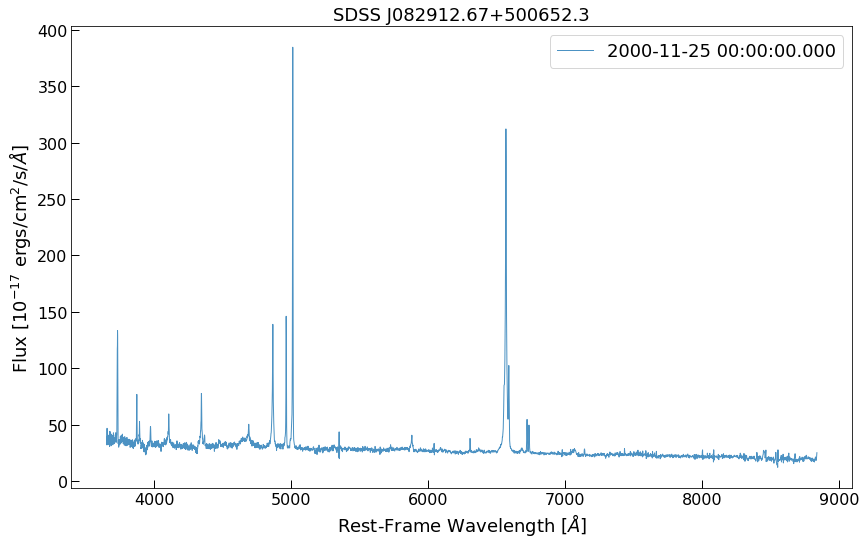

In [2]:
#Find the spectrum
pos = coords.SkyCoord('08h29m12.67s +50d06m52.3s', frame='icrs')
xid = SDSS.query_region(pos, spectro=True,radius=5*u.arcsec)
sp = SDSS.get_spectra(matches=xid)

fig, ax = plt.subplots(figsize=(14.,8.5))
for i in np.arange(xid['ra'].size):
    hdr=sp[i][0].header
    t   =Time(float(hdr['MJD']),format='mjd')
    t.format='iso'
    ax.plot((10.**sp[i][1].data['loglam'])/(1+sp[i][2].data['z'][0]),sp[i][1].data['flux'],label=t.value,linewidth=1,alpha=0.8)
ax.set_ylabel(r'Flux [10$^{-17}$ ergs/cm$^2$/s/$\AA$]',fontsize=18)
ax.set_xlabel('Rest-Frame Wavelength [$\AA$]',fontsize=18)
ax.legend(loc='upper right',fontsize=18)
ax.set_title('SDSS J082912.67+500652.3',fontsize=18)

### Read data and correct the Milky Way extinction
* Check [here](https://github.com/kbarbary/sfddata) for dust map
* Check [here](https://github.com/sczesla/PyAstronomy/tree/master) for the dust correction

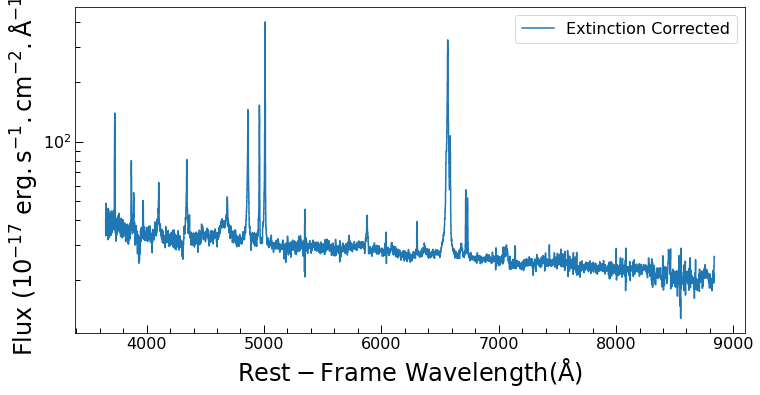

In [3]:
#Select the first spectrum and make the dust correction from the Milky Way (Schlegel, Finkbeiner and Davis 1998)
hdu = sp[0]
lam_res_unred, flux_res_unred, err_unred = sagan.ReadSpectrum(is_sdss=True, hdu=hdu).unredden_res()

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(lam_res_unred, flux_res_unred, label='Extinction Corrected', c='C0')
ax.set_yscale('log')
ax.set_xlabel(r'$\rm {Rest-Frame \ Wavelength (\AA)}$',fontsize=24)
ax.set_ylabel(r'$\rm {Flux \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$',fontsize=24)
ax.legend(fontsize=16)
ax.minorticks_on()
plt.show()

### Cut the useful data
* First move to the rest frame
* Cut the wavelength range following Kuhn et al. (2024)

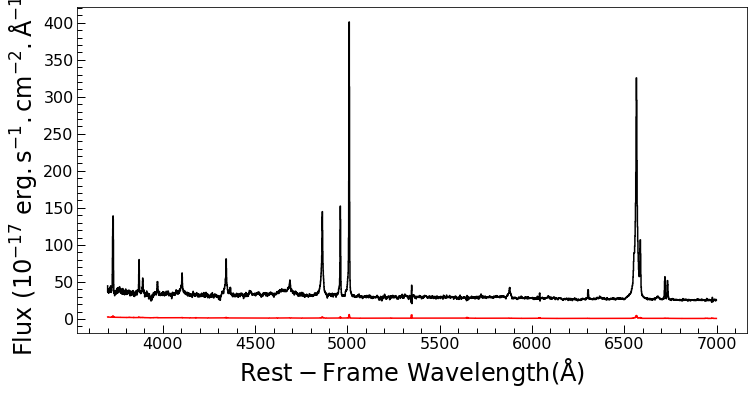

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 3700, 7000
fltr = (lam_res_unred > wmin) & (lam_res_unred < wmax)
wave_use = lam_res_unred[fltr]
flux_use = flux_res_unred[fltr]
ferr = err_unred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.step(wave_use, ferr, color='r')
ax.set_xlabel(r'$\rm {Rest-Frame \ Wavelength (\AA)}$',fontsize=24)
#ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.set_ylabel(r'$\rm {Flux \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$',fontsize=24)
ax.minorticks_on()
plt.show()

### Fit spectrum
* Check the emission lines here: http://astronomy.nmsu.edu/drewski/tableofemissionlines.html
* Tie all the narrow lines to [S II] $\lambda\lambda$ 6718,6733 doublet
* Iterate many times until you find a good result
* * The continuum will be fitted using the FeII + PL + Star (A, F, G, K, M) model to a specified spectral window.
* * Fitting [S II] line and using it as narrow line template, fixing the shape of the continuum and optionally fitting its amplitude
* * Fitting other lines, using narrow line template ([S II]) and fixing the shape of the continuum and optionally fitting its amplitude

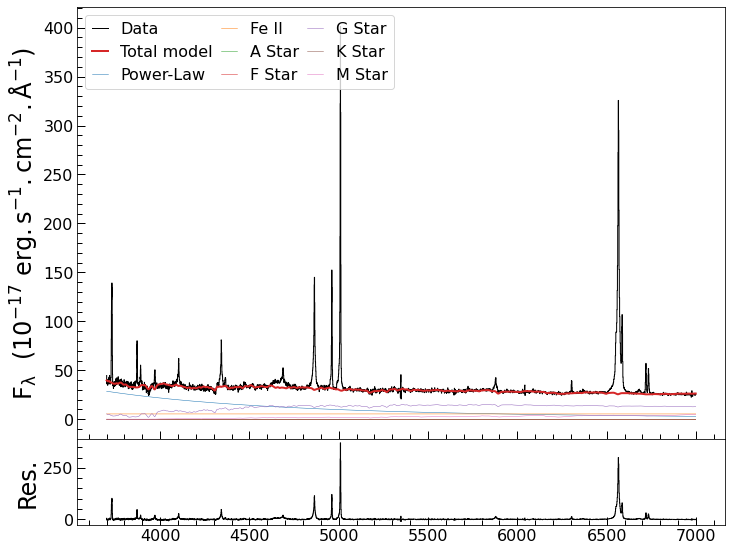

In [5]:
cont_window_lo = [3700, 3740, 4041, 4150, 5550, 6000, 6400]
cont_window_up = [3715, 3800, 4043, 4250, 5850, 6290, 6450]
ins = np.zeros_like(wave_use, dtype=bool)
for i in range(len(cont_window_up)):
    ins |= (wave_use > cont_window_lo[i]) & (wave_use < cont_window_up[i])
cont_x = wave_use[ins]
cont_y = flux_use[ins]
cont_y_e = ferr[ins]
sdss_velscale = 69.03

pl = models.PowerLaw1D(amplitude=0.55, x_0=5500, alpha=1.0, fixed={'x_0': True}, name='Power-Law')
iron = sagan.IronTemplate(amplitude=0.2, stddev=500, z=0, name='Fe II')
iron.z.fixed = True
Star_A = sagan.StarSpectrum(amplitude=0.2, sigma=50, velscale=sdss_velscale, Star_type='A', name='A Star')
Star_F = sagan.StarSpectrum(amplitude=0.2, sigma=50, velscale=sdss_velscale, Star_type='F', name='F Star')
Star_G = sagan.StarSpectrum(amplitude=0.2, sigma=50, velscale=sdss_velscale, Star_type='G', name='G Star')
Star_K = sagan.StarSpectrum(amplitude=0.2, sigma=50, velscale=sdss_velscale, Star_type='K', name='K Star')
Star_M = sagan.StarSpectrum(amplitude=0.2, sigma=50, velscale=sdss_velscale, Star_type='M', name='M Star')

m_init = pl + iron + Star_A + Star_F + Star_G + Star_K + Star_M

def tie_v(model):
    return model['A Star'].sigma

for tem in [Star_F, Star_G, Star_K, Star_M]:
    tem.sigma.tied = tie_v

fitter = fitting.LevMarLSQFitter()

conti_weights = 1/(cont_y_e)
weights = 1/ferr
m_fit_cont = fitter(m_init, cont_x, cont_y, weights=conti_weights, maxiter=10000)  

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_cont, weight=weights)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
plt.show()

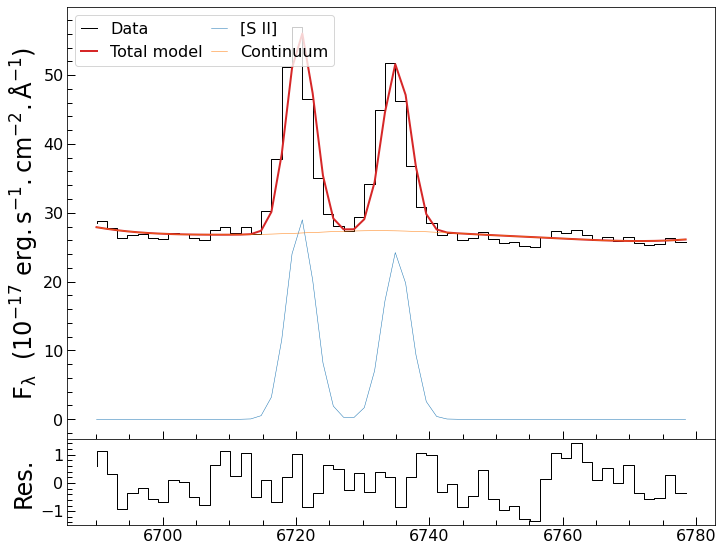

In [6]:
ins = (wave_use>6690)&(wave_use<6780)

wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict
bounds = {'sigma_c': (30, 4000), 'dv_c':(-2000, 2000)}
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=1, amp_c1=1,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')
poly = models.Polynomial1D(degree=5, name='multi')
def m_fit_cont_func(x):
    return m_fit_cont(x)
cont = sagan.TierContinuum(y_func=m_fit_cont_func, amplitude=1.0, name=f'Continuum')
cont.amplitude.fixed = True

m_init  = (line_s2+cont)*poly
fitter = fitting.LevMarLSQFitter(calc_uncertainties=True)

weights = 1/ferr

m_fit_SII = fitter(m_init, wave_use[ins], flux_use[ins], weights=weights[ins], maxiter=20000, filter_non_finite=True, estimate_jacobian=True)

ax, axr = sagan.plot.plot_fit(wave_use[ins], flux_use[ins], m_fit_SII, weight=weights[ins])
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
plt.show()

### Create a narrow line template using [S II]

In [7]:
c_km = 2.99792458e5

n_SII = sagan.Line_Gaussian(amplitude=m_fit_SII.amp_c0_0.value, sigma=m_fit_SII.sigma_c_0.value, wavec=m_fit_SII.wavec0_0.value)
m_tmpl = m_fit_SII['multi']*n_SII
velc_SII_tmpl = np.linspace(-1000, 1000, 6000)
lam_SII_tmpl = (velc_SII_tmpl/c_km+1)*m_fit_SII.wavec0_0.value
flux_SII_tmpl = m_tmpl(lam_SII_tmpl)

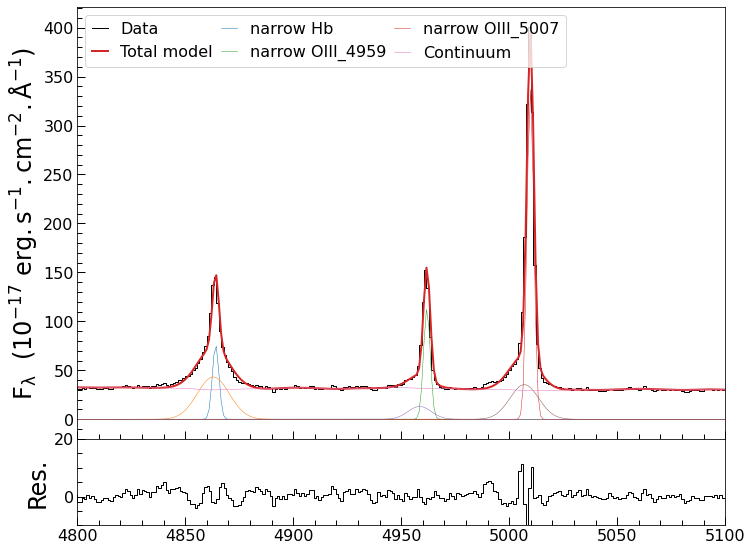

In [8]:
n_hb = sagan.Line_template(template_velc=velc_SII_tmpl, template_flux=flux_SII_tmpl, amplitude=3, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
#line_o3 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=1.7, amp_c1=0.6, dv_c=-43, sigma_c=250, 
#                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]')
n_OIII_1 = sagan.Line_template(template_velc=velc_SII_tmpl, template_flux=flux_SII_tmpl, amplitude=3, wavec=wave_dict['OIII_4959'], name=f'narrow OIII_4959')
n_OIII_2 = sagan.Line_template(template_velc=velc_SII_tmpl, template_flux=flux_SII_tmpl, amplitude=3, wavec=wave_dict['OIII_5007'], name=f'narrow OIII_5007')

b_hb = sagan.Line_Gaussian(amplitude=3, wavec=wave_dict['Hbeta']) 
b_OIII_1 = sagan.Line_Gaussian(amplitude=1, wavec=wave_dict['OIII_4959']) #, name=f'broad OIII_4959'
b_OIII_2 = sagan.Line_Gaussian(amplitude=1, wavec=wave_dict['OIII_5007']) #, name=f'broad OIII_5007'


def tie_o3(model):
    return model['narrow OIII_5007'].amplitude / 2.98
n_OIII_1.amplitude.tied = tie_o3

#def tie_o3(model):
#    return model['[O III]'].amp_c0 / 2.98
#line_o3.amp_c1.tied = tie_o3

line_hb = n_hb+b_hb
line_OIII = n_OIII_1+n_OIII_2+b_OIII_1+b_OIII_2
    
m_init = line_hb+ line_OIII + cont

fitter = fitting.LevMarLSQFitter()
ins = ((wave_use>4800)&(wave_use<5100))

weights_lines = 1/ferr[ins]
weights = 1/ferr

m_fit_Hb = fitter(m_init, wave_use[ins], flux_use[ins], weights=weights_lines, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_Hb, weight=weights)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
ax.set_xlim(4800,5100)
axr.set_xlim(4800,5100)
axr.set_ylim(-10, 20)
plt.show()

/Users/liguodong/Macbook-liguodong/KIAA/IRAS_SDSS/Sample/v2/Test/Spec_fit/SAGAN-Modified/example/../../SAGAN-Modified/sagan/line_profile.py:251: RuntimeWarning: divide by zero encountered in true_divide
  amp_c * params[4 + i * n_pars] * np.exp(-0.5 * ((v - dv - params[5 + i * n_pars]) / params[6 + i * n_pars])**2)


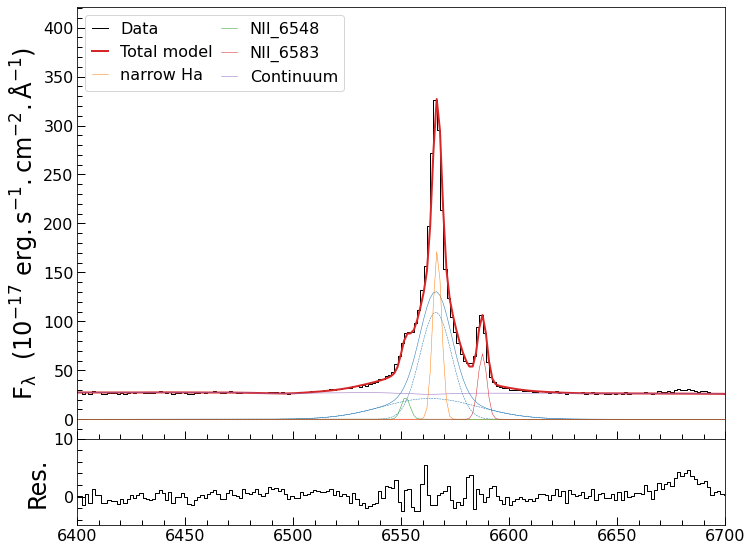

In [9]:
n_ha = sagan.Line_template(template_velc=velc_SII_tmpl, template_flux=flux_SII_tmpl, amplitude=3, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_NII_1 = sagan.Line_template(template_velc=velc_SII_tmpl, template_flux=flux_SII_tmpl, amplitude=3, wavec=wave_dict['NII_6548'], name=f'NII_6548')
n_NII_2 = sagan.Line_template(template_velc=velc_SII_tmpl, template_flux=flux_SII_tmpl, amplitude=3, wavec=wave_dict['NII_6583'], name=f'NII_6583')
bounds_Ha = {'sigma': (100, 30000), 'dv':(-1000, 200)}
b_ha = bounds = {'sigma_w0': (100, 4000)}
b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=2, dv_c=280, sigma_c=830, 
                             wavec=wave_dict['Halpha'],
                             amp_w0=2, dv_w0=-185, sigma_w0=2400)

def tie_n2(model):
    return model['NII_6583'].amplitude / 2.96
n_NII_1.amplitude.tied = tie_n2

#def tie_n2_dv(model):
#    return model['NII_6583'].dv
#n_NII_1.dv.tied = tie_n2

line_ha = b_ha+n_ha
line_NII = n_NII_1+n_NII_2
    
m_init = line_ha+line_NII+cont

fitter = fitting.LevMarLSQFitter()
ins = ((wave_use>6400)&(wave_use<6700))

weights_lines = 1/ferr[ins]
weights = 1/ferr

m_fit_Ha = fitter(m_init, wave_use[ins], flux_use[ins], weights=weights_lines, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit_Ha, weight=weights)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
ax.set_xlim(6400,6700)
axr.set_ylim(-5, 10)
plt.show()

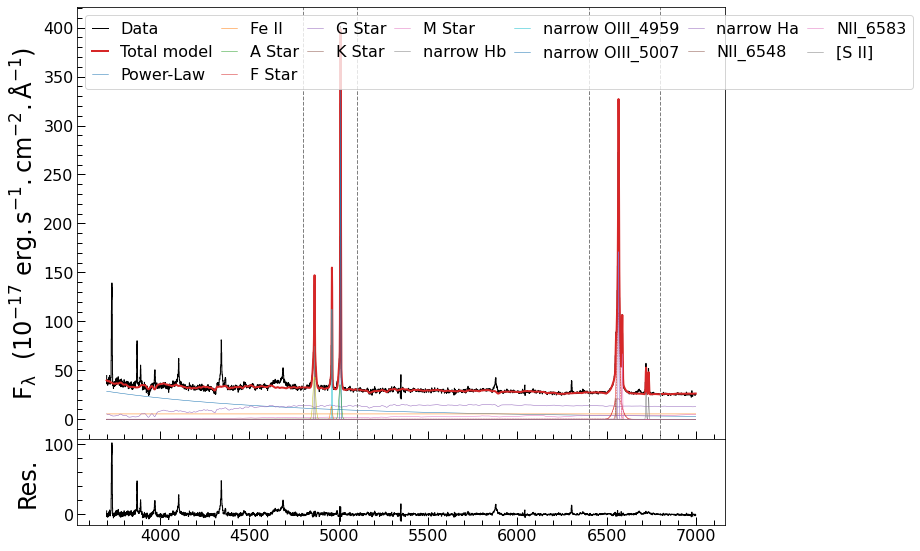

In [10]:
m_fit_cont
m_fit_SII_no_cont = m_fit_SII['[S II]']
m_fit_Hb_no_cont = m_fit_Hb.left
m_fit_Ha_no_cont = m_fit_Ha.left
m_fit = m_fit_cont+m_fit_Hb_no_cont+m_fit_Ha_no_cont+m_fit_SII_no_cont
ax, axr = sagan.plot.plot_fit(wave_use, flux_use,m_fit, weight=weights)
ax.set_ylabel(r'$\rm {F_\lambda\ \ (10^{-17} \ erg.s^{-1}.cm^{-2}.{\AA}^{-1})}$', fontsize=24)
ax.axvline(x=4800, linewidth=1, linestyle='--', color='gray')
ax.axvline(x=5100, linewidth=1, linestyle='--', color='gray')
ax.axvline(x=6400, linewidth=1, linestyle='--', color='gray')
ax.axvline(x=6800, linewidth=1, linestyle='--', color='gray')
plt.show()